# Classify a face: **real** or created by **GAN**?

**Accesso** al drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Mounted at /gdrive
/gdrive/My Drive


Calculate the azimuthally averaged radial profile.

In [ ]:
# from https://www.astrobetter.com/blog/2010/03/03/fourier-transforms-of-images-in-python/
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

**1. Feature extraction**

In [ ]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import pickle
import shutil

In [ ]:
path_datasets = ['././FFHQ', './celebA-HQ_4k', './StyleGAN1', './StyleGAN2']
label_datasets = [0, 0, 1, 1]
format_file_datasets = ['png', 'jpg', 'png', 'png']

dataset_name = [] # insert value of path_datasets eg. path_datasets[0]...
labels = [] # insert value of labels_datsets 
format_file = [] # insert value of format_file_datasets

epsilon = 1e-8
data = {}
DIM = 722 # 722 per img. 1024x1024, 139 per img. 178x218
#number of samples from each dataset
stop = 4000
number_iter = len(dataset_name) * stop
psd1D_total = np.zeros([number_iter, DIM])
label_total = np.zeros([number_iter])
iter_ = 0

for z in range(len(dataset_name)):
    cont = 0
    psd1D_average_org = np.zeros(DIM)
    print(dataset_name[z]) 
    
    for filename in glob.glob(dataset_name[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)
        print(filename)

        #if (dataset_name_6[0] == './celebA2000') and (dataset_name_6[z] != './celebA2000'):
            #img = cv2.resize(img, (178, 218), interpolation=cv2.INTER_CUBIC)

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = azimuthalAverage(magnitude_spectrum)
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]
        #print(labels[z])

        cont+=1
        iter_+=1
        if cont >= stop: # (cont >= stop and dataset_name_6[z] != './StyleGAN2') or (cont >= 4000 and dataset_name_6[z] == './StyleGAN2'):
            break

data["data"] = psd1D_total
data["label"] = label_total

"""
  ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN1.pkl 
  or ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN2.pkl 
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN2.pkl'
"""
file_path = './Biometric_system_project/dataset_freq_celebA-HQ_4k.pkl'
output = open(file_path, 'wb') 
pickle.dump(data, output)
output.close()
print("DATA Saved")

**2. Load feature**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

"""
  ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN1.pkl 
  or ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN2.pkl 
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN2.pkl'
"""

path_file = './Biometric_system_project/dataset_freq_FFHQ.pkl'

# load feature file
pkl_file = open(path_file, 'rb') 
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]
plt.plot(y) # print distribution classes assigned to the samples

**3. Spectrum analysis**

In [ ]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

**3.1 Spectrum analysis single image**

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

epsilon = 1e-8
filename = [['./celebA-HQ_4k/9.jpg', './celebA-HQ_4k/13.jpg', './celebA-HQ_4k/16.jpg'], 
            ['./FFHQ/00001.png', './FFHQ/00015.png', './FFHQ/00018.png'], 
            ['./StyleGAN1/000000.png', './StyleGAN1/000003.png', './StyleGAN1/000017.png'], 
            ['./StyleGAN2/000000.png', './StyleGAN2/000009.png', './StyleGAN2/000015.png']]

for i in range(len(filename)):
  for j in range(len(filename[i])):
    img = cv2.imread(filename[i][j],0)
    img_color = mpimg.imread(filename[i][j])
    # Calculate FFT
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = azimuthalAverage(magnitude_spectrum)

    #Visualization
    fig = plt.figure(figsize=(40, 5))
    ax = fig.add_subplot(151)
    plt.axis('off')
    ax3 = fig.add_subplot(152)
    ax2 = fig.add_subplot(153)

    if i <= 1 and i == 0:
      ax.set_title('input image "real" from celebA-HQ dataset',size=15)
    elif i <= 1 and i == 1:
      ax.set_title('input image "real" from FFHQ dataset',size=15)
    elif i > 1 and i == 2:
      ax.set_title('input image "fake" from StyleGAN1 dataset',size=15)
    elif i > 1 and i == 3:
      ax.set_title('input image "fake" from StyleGAN2 dataset',size=15)

    ax2.set_title('1D Power Spectrum',size=15)
    ax3.set_title('2D-DFT', size=15)
    plt.xlabel('Spatial Frequency', fontsize=20)
    plt.ylabel('Power Spectrum', fontsize=20)
    ax.imshow(img_color)
    ax2.plot(psd1D)
    ax3.imshow(magnitude_spectrum, "gray")
    plt.show()

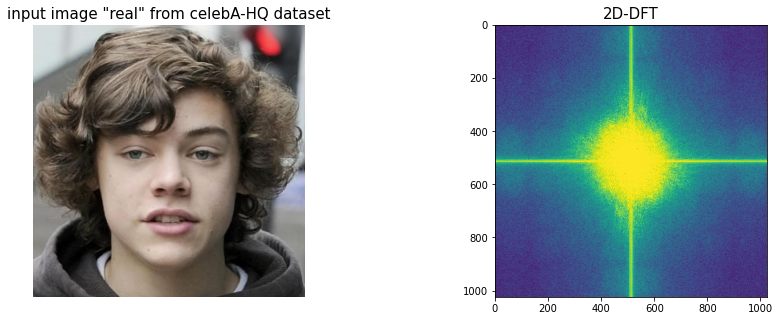

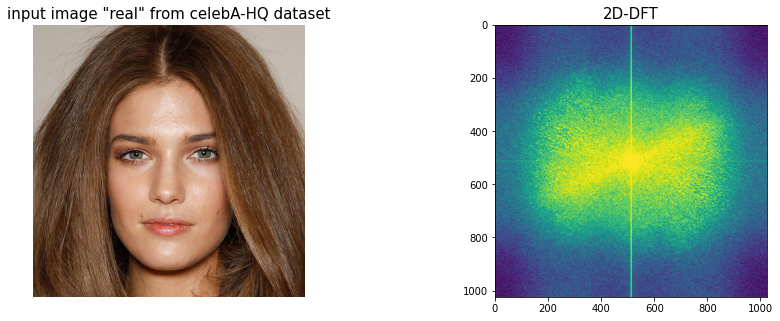

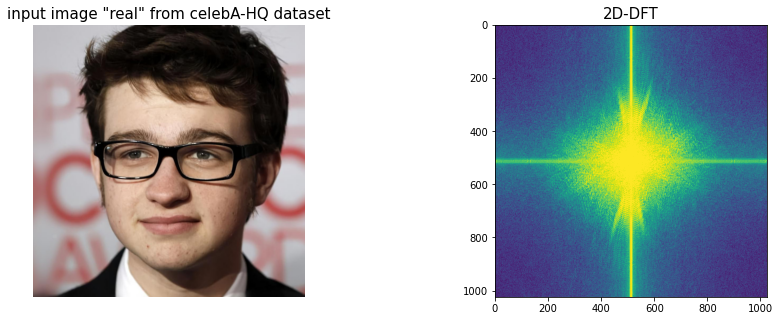

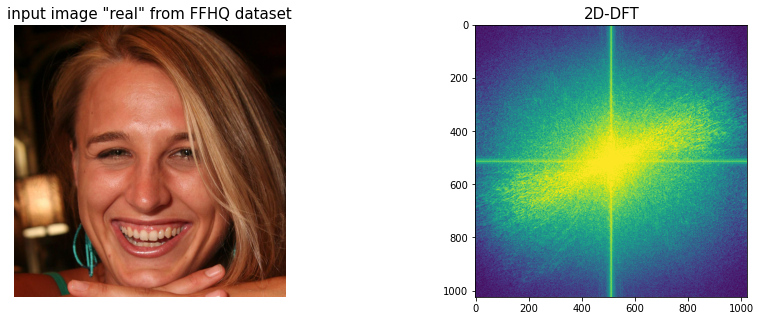

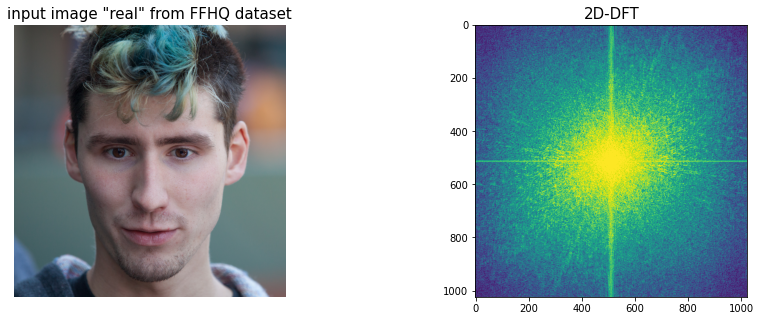

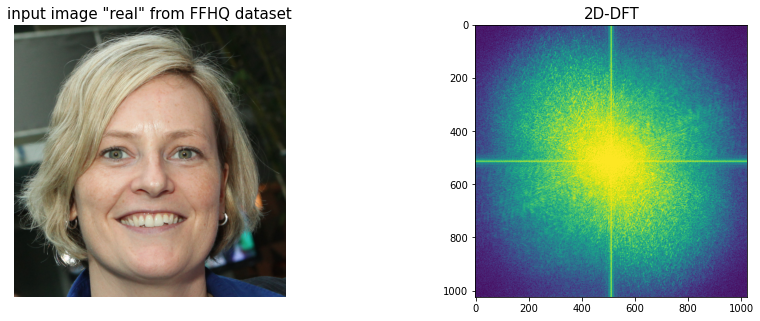

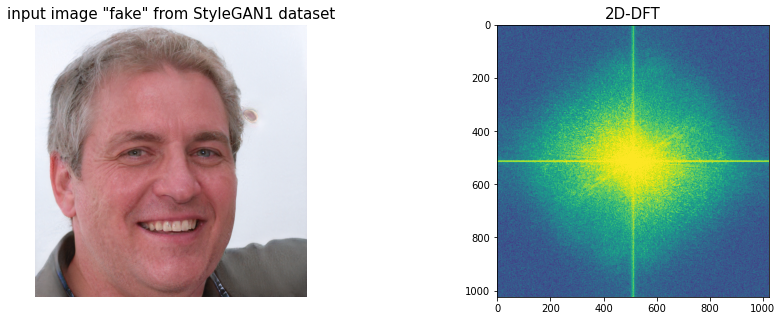

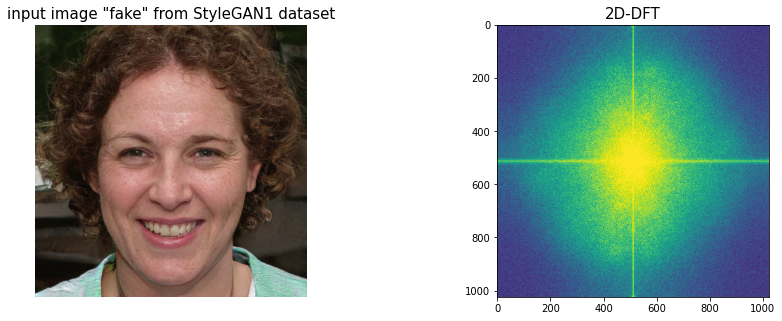

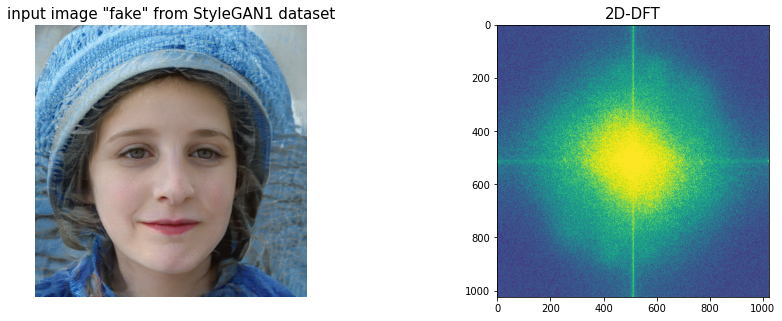

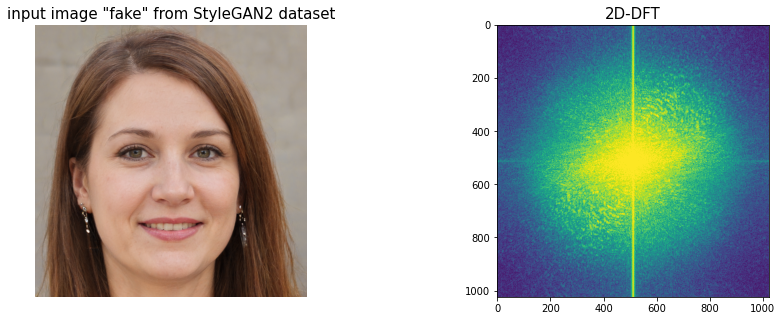

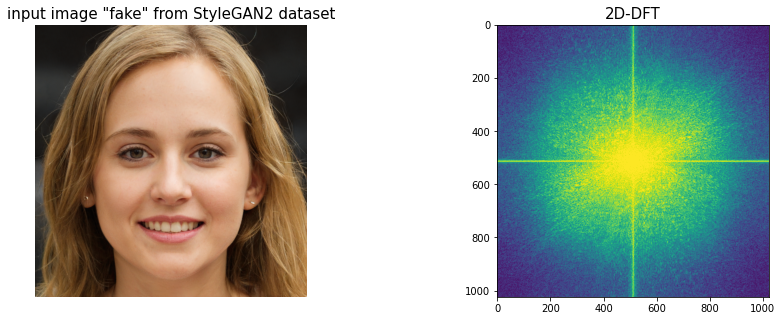

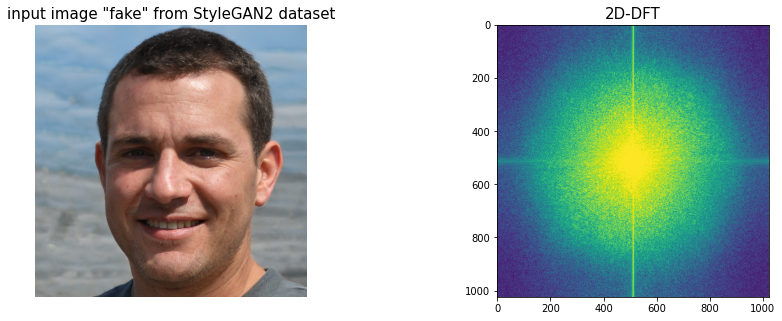

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage.color import rgb2gray

filename = [['./celebA-HQ_4k/9.jpg', './celebA-HQ_4k/13.jpg', './celebA-HQ_4k/16.jpg'], 
            ['./FFHQ/00001.png', './FFHQ/00015.png', './FFHQ/00018.png'], 
            ['./StyleGAN1/000000.png', './StyleGAN1/000003.png', './StyleGAN1/000017.png'], 
            ['./StyleGAN2/000000.png', './StyleGAN2/000009.png', './StyleGAN2/000015.png']]

for i in range(len(filename)):
  for j in range(len(filename[i])):
    im = io.imread(filename[i][j])
    img_color = mpimg.imread(filename[i][j])
    # Calculate FFT
    im = im.astype(np.float32)
    im = im/255.0
    for k in range(3):
        img = im[:, :, k]
        fft_img = np.fft.fft2(img)
        fft_img = np.log(np.abs(fft_img)+1e-3)
        fft_min = np.percentile(fft_img,5)
        fft_max = np.percentile(fft_img,95)
        fft_img = (fft_img - fft_min)/(fft_max - fft_min)
        fft_img = (fft_img-0.5)*2
        fft_img[fft_img<-1] = -1
        fft_img[fft_img>1] = 1
        fft_img = np.fft.fftshift(fft_img)  # basse frequenza le porta al centro dell'img
        im[:, :, k] = fft_img

    #Visualization
    fig = plt.figure(figsize=(40, 5))
    ax = fig.add_subplot(151)
    plt.axis('off')
    ax3 = fig.add_subplot(152)
    #ax2 = fig.add_subplot(153)

    if i <= 1 and i == 0:
      ax.set_title('input image "real" from celebA-HQ dataset',size=15)
    elif i <= 1 and i == 1:
      ax.set_title('input image "real" from FFHQ dataset',size=15)
    elif i > 1 and i == 2:
      ax.set_title('input image "fake" from StyleGAN1 dataset',size=15)
    elif i > 1 and i == 3:
      ax.set_title('input image "fake" from StyleGAN2 dataset',size=15)

    #ax2.set_title('1D Power Spectrum',size=15)
    ax3.set_title('2D-DFT', size=15)
    #plt.xlabel('Spatial Frequency', fontsize=20)
    #plt.ylabel('Power Spectrum', fontsize=20)
    ax.imshow(img_color)
    #ax2.plot(psd1D)
    im = rgb2gray(im)
    ax3.imshow(im)
    plt.show()

**4. Train and test classification**

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [ ]:
# apply layered k fold cross validation
def stratified_k_fold_validation(x, y, n_fold):
    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    x_train = []; x_test = []; y_train = []; y_test = [];
    for train_index, test_index in skf.split(X=x, y=y):
        x_train.append(x.iloc[train_index])
        x_test.append(x.iloc[test_index])
        y_train.append(y.iloc[train_index])
        y_test.append(y.iloc[test_index])

    return x_train, x_test, y_train, y_test


# svm classifier
def SVM_configuration(X, y, kernel_type):
    clf = SVC(kernel=kernel_type)
    clf.fit(X, y)

    return clf


# random forest classifier
def random_forest_configuration(X, y, randomization, bootstrap, n_estimators):
    clf = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=0.05,
                                 max_features=randomization, max_samples=bootstrap)
    clf.fit(X, y)

    return clf


# evaluate samples with a classifier clf
def evaluate(X, y_true, clf):
    metrics = []
    y_pred = clf.predict(X)
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import balanced_accuracy_score
    metrics.append(accuracy_score(y_true, y_pred))  # oa
    metrics.append(balanced_accuracy_score(y_true, y_pred))  # balanced accuracy
    metrics.append(precision_score(y_true, y_pred))  # precision
    metrics.append(recall_score(y_true, y_pred))  # recall
    metrics.append(f1_score(y_true, y_pred))  # fscore
    return metrics


# evaluate different kernel type for SVM by fscore metric
def evaluateCV(kfolds, ListXTrain, ListXTest, ListYTrain, ListYTest, kernel_type):
    avgTrain = [0.0, 0.0, 0.0, 0.0, 0.0]
    avgTest = [0.0, 0.0, 0.0, 0.0, 0.0]

    for i in range(kfolds):
        clf = SVM_configuration(ListXTrain[i], ListYTrain[i], kernel_type)
        metrics = evaluate(ListXTrain[i], ListYTrain[i], clf)
        avgTrain = [x + y for x, y in zip(avgTrain, metrics)]
        metrics = evaluate(ListXTest[i], ListYTest[i], clf)
        avgTest = [x + y for x, y in zip(avgTest, metrics)]

    avgTrain = [x / kfolds for x in avgTrain]
    avgTest = [x / kfolds for x in avgTest]

    return avgTrain, avgTest


# evaluate different estimators, randomization and bootstrap type for Random Forest by fscore metric
def evaluateCV_RF(kfolds, ListXTrain, ListXTest, ListYTrain, ListYTest, n_estimators, randomization, bootstrap):
    avgTrain = [0.0, 0.0, 0.0, 0.0, 0.0]
    avgTest = [0.0, 0.0, 0.0, 0.0, 0.0]

    for i in range(kfolds):
        clf = random_forest_configuration(ListXTrain[i], ListYTrain[i], randomization, bootstrap, n_estimators)
        metrics = evaluate(ListXTrain[i], ListYTrain[i], clf)
        avgTrain = [x + y for x, y in zip(avgTrain, metrics)]
        metrics = evaluate(ListXTest[i], ListYTest[i], clf)
        avgTest = [x + y for x, y in zip(avgTest, metrics)]

    avgTrain = [x / kfolds for x in avgTrain]
    avgTest = [x / kfolds for x in avgTest]

    return avgTrain, avgTest


# Evaluate all configurations available for list_kernel_type. Returns the best kernel_type configuration
def best_learned_configuration_SVM(X_train, X_test, Y_train, Y_test, kfolds, list_kernel_type):
    best_f_score = 0.0
    best_kernel = ""
    i = 1

    for k in list_kernel_type:
        print("configuration n"+str(i)+": " + "kernel_type="+k)
        avgTrain, avgTest = evaluateCV(kfolds, X_train, X_test, Y_train, Y_test, k)
        if avgTest[-1] > best_f_score:
            best_f_score = avgTest[-1]
            best_kernel = k
            print("Best configuration for now: "+best_kernel+" "+" (fscore="+str(avgTest[-1])+")")
        i += 1

    return {"kernel_type":best_kernel}


# Evaluate all configurations available for list randomization, bootstrap and estimators. Returns the best configuration
def best_learned_configuration_random_forest(X_train, X_test, Y_train, Y_test, kfolds, list_randomization, list_bootstrap, list_n_estimators):
    best_f_score = 0.0
    best_randomization = ""
    best_bootstrap = 0.0
    best_n_estimator = 0
    i = 1

    for randomization in list_randomization:
        for bootstrap in list_bootstrap:
            for estimator in list_n_estimators:
                print("configuration n"+str(i)+": " + "randomization="+randomization+
                      " bootstrap="+str(bootstrap)+" n_estimator="+str(estimator))
                avgTrain, avgTest = evaluateCV_RF(kfolds, X_train, X_test, Y_train, Y_test, estimator, randomization, bootstrap)
                if avgTest[-1] > best_f_score:
                    best_f_score = avgTest[-1]
                    best_randomization = randomization
                    best_bootstrap = bootstrap
                    best_n_estimator = estimator
                    print("Best configuration for now: "+best_randomization+" "+str(best_bootstrap)+" "
                          +str(best_n_estimator)+" (fscore="+str(avgTest[-1])+")")
                i += 1

    return {"randomization":best_randomization, "bootstrap":best_bootstrap, "n_estimators":best_n_estimator}  # [best_randomization, best_bootstrap, best_n_estimator]


# Print single score list
def print_evaluation(evaluation):
    print("overall_accuracy_score="+str(evaluation[0])+" balanced_accuracy_score="+str(evaluation[1])+
          " precision_score="+str(evaluation[2])+" recall_score="+str(evaluation[3])+" f1_score="+str(evaluation[4]))
    print(sep='\n\n')


# Plot confusion matrix
def plot_confusion(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print('Confusion matrix shape:', conf_matrix.shape)
    
    plt.imshow(conf_matrix)
    plt.xticks([0, 1], ['real', 'fake'], fontsize=16)
    plt.yticks([0, 1], ['real', 'fake'], fontsize=16)
    plt.ylabel('Truth', fontsize=20)
    plt.xlabel('Prediction', fontsize=20)
    plt.colorbar()

    plt.grid(False)
    plt.show()


# Append two or more Pandas data frame
def concat_data_frame(df_list=list()):
    return pd.concat(df_list)


# Read pkl file and return a Pandas data frame
def get_data_frame(path):
    pkl_file = open(path, 'rb')

    data = pickle.load(pkl_file)
    print(data)

    pkl_file.close()
    X = data["data"]
    # print(type(X))
    y = data["label"]
    y = y.tolist()
    # print(type(y))

    df = pd.DataFrame(X)
    df.insert(loc=len(df.columns), column=len(df.columns + 1), value=y)

    return df


# Return features (X) and labels (y)
def get_X_y(df):
    X = df.iloc[:, :-1]; y = df.iloc[:, -1]
    return X, y

In [ ]:
"""
  ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN1.pkl 
  or ./Biometric_system_project/dataset_freq_FFHQ_StyleGAN2.pkl 
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN2.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN1.pkl'
  or './Biometric_system_project/dataset_freq_celebA2000_FFHQ2000_StyleGAN2.pkl'
"""
# read python dict back from the file
# df = get_data_frame('./Biometric_system_project/dataset_freq_celebA-HQ_4k_StyleGAN2.pkl')
# X, y = get_X_y(df)

df1 = get_data_frame('./Biometric_system_project/dataset_freq_FFHQ.pkl')
df2 = get_data_frame('./Biometric_system_project/dataset_freq_celebA-HQ_4k.pkl')
df3 = get_data_frame('./Biometric_system_project/dataset_freq_StyleGAN1.pkl')
df4 = get_data_frame('./Biometric_system_project/dataset_freq_StyleGAN2.pkl')

df5 = concat_data_frame([df1, df2, df3, df4])
X, y = get_X_y(df5)
# plt.plot(y)

{'data': array([[321.57192799, 307.92529832, 293.55659045, ..., 119.077996  ,
        123.96095485, 123.24541631],
       [319.59058506, 303.94031633, 299.16444379, ..., 114.66811618,
        111.76847425,  99.44991015],
       [317.42273507, 306.68606744, 297.99637341, ..., 114.92447208,
        109.29211174, 113.24670364],
       ...,
       [318.66501644, 303.75699255, 297.92171919, ..., 120.65410937,
        115.39635401, 114.58639897],
       [300.71824735, 307.48918647, 297.61728359, ..., 109.08615117,
        108.62335008, 110.35792936],
       [311.60842293, 300.53198856, 299.95058064, ..., 114.62728415,
        116.59397314, 122.21567533]]), 'label': array([0., 0., 0., ..., 0., 0., 0.])}
{'data': array([[316.44014752, 301.04306876, 296.16210955, ..., 110.48902249,
        109.80517721, 108.65179535],
       [305.60847316, 297.21871572, 290.4972448 , ..., 109.57540474,
        107.68284071, 108.0464366 ],
       [312.72088587, 301.86787484, 287.65536561, ..., 108.48063729,
    

Best configuration phase...
configuration n1: kernel_type=linear
Best configuration for now: linear  (fscore=0.9865606960277798)
configuration n2: kernel_type=poly
Best configuration for now: poly  (fscore=0.9976617297747058)
configuration n3: kernel_type=rbf
configuration n1: randomization=sqrt bootstrap=0.5 n_estimator=10
Best configuration for now: sqrt 0.5 10 (fscore=0.9477862703046421)
configuration n2: randomization=sqrt bootstrap=0.5 n_estimator=20
configuration n3: randomization=sqrt bootstrap=0.5 n_estimator=30
configuration n4: randomization=sqrt bootstrap=0.6 n_estimator=10
configuration n5: randomization=sqrt bootstrap=0.6 n_estimator=20
configuration n6: randomization=sqrt bootstrap=0.6 n_estimator=30
Best configuration for now: sqrt 0.6 30 (fscore=0.9488761045485408)
configuration n7: randomization=sqrt bootstrap=0.7 n_estimator=10
configuration n8: randomization=sqrt bootstrap=0.7 n_estimator=20
Best configuration for now: sqrt 0.7 20 (fscore=0.9498168921081002)
configur

'\n  from sklearn.model_selection import train_test_split\n  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)\n\n  from sklearn.svm import SVC\n  svclassifier = SVC(kernel=\'linear\')\n  svclassifier.fit(X_train, y_train)\n  print(\'Accuracy on test set: {:.3f}\'.format(svclassifier.score(X_test, y_test)))\n  \n  from sklearn.linear_model import LogisticRegression\n  logreg = LogisticRegression(solver=\'liblinear\', max_iter=1000)\n  logreg.fit(X_train, y_train)\n  print(\'Accuracy on test set: {:.3f}\'.format(logreg.score(X_test, y_test)))\n\n  \n  SVM+=svclassifier.score(X_test, y_test)\n  LR+=logreg.score(X_test, y_test)\n\n\n  num-=1\n  print(num)\n  \n  print("Average SVM: "+str(SVM/num))\n  print("Average LR: "+str(LR/num))\n'

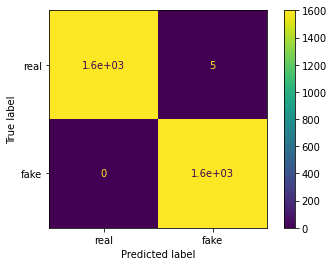

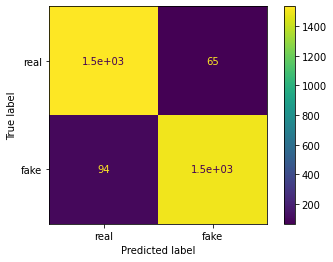

In [ ]:
# num = 10
# LR = 0
# SVM = 0
n_fold = 5 # parameter for k fold cross validation

# for SVM
list_kernel_type = ['linear', 'poly', 'rbf']

# for random forest
list_randomization = ["sqrt", "log2"]  # Random forest max_features parameter
list_bootstrap = [0.5, 0.6, 0.7, 0.8, 0.9]  # Random forest max_samples parameter
list_n_estimators = [10, 20, 30]  # Random forest n_estimators parameter

path_model = './Biometric_system_project/Model/' # path where save model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42) # split into train and test

X_train_kfold, X_test_kfold, Y_train_kfold, Y_test_kfold = stratified_k_fold_validation(X_train, y_train, n_fold) # k fold cross validation

dict_configuration_SVM = dict() # dict for SVM parameters
dict_configuration_RF = dict() # dict for Random forest parameters

print("Best configuration phase...")
dict_configuration_SVM = best_learned_configuration_SVM(X_train_kfold, X_test_kfold, Y_train_kfold, Y_test_kfold,
                                                             n_fold, list_kernel_type)

dict_configuration_RF = best_learned_configuration_random_forest(X_train_kfold, X_test_kfold, Y_train_kfold, Y_test_kfold,
                                                             n_fold, list_randomization, list_bootstrap, list_n_estimators)

print("Best configuration SVM : kernel="+str(dict_configuration_SVM["kernel_type"]))
print("Best configuration Random Forest: randomization="+str(dict_configuration_RF["randomization"])+
          " bootstrap="+str(dict_configuration_RF["bootstrap"])+
          " n_estimators="+str(dict_configuration_RF["n_estimators"]))
print(sep='\n\n')

print("Train phase...")
SVM = SVM_configuration(X_train, y_train, dict_configuration_SVM["kernel_type"])
RANDOM_FOREST = random_forest_configuration(X_train, y_train, dict_configuration_RF["randomization"],
                                                                 dict_configuration_RF["bootstrap"],
                                                                 dict_configuration_RF["n_estimators"])
# save and load model
svm_model_name = 'SVM_freq_FFHQ_celebA-HQ_4k_StyleGAN1_StyleGAN2.pkl'
rf_model_name = 'RF_freq_FFHQ_celebA-HQ_4k_StyleGAN1_StyleGAN2.pkl' 

pickle.dump(SVM, open(path_model+svm_model_name, 'wb'))
pickle.dump(RANDOM_FOREST, open(path_model+rf_model_name, 'wb'))

SVM_LOADED = pickle.load(open(path_model+svm_model_name, 'rb')) 
RANDOM_FOREST_LOADED = pickle.load(open(path_model+rf_model_name, 'rb'))

# test phase
print("Test pahese...")
evaluation_SVM = evaluate(X_test, y_test, SVM_LOADED)
evaluation_RF = evaluate(X_test, y_test, RANDOM_FOREST_LOADED)

# Pattern comparison
# SVM
print("SVM")
print_evaluation(evaluation_SVM)
y_pred_SVM = SVM_LOADED.predict(X_test)
print(confusion_matrix(y_test, y_pred_SVM))
print(classification_report(y_test, y_pred_SVM, target_names=['real', 'fake'], digits=5))
plot_confusion_matrix(SVM_LOADED, X_test, y_test, display_labels=['real', 'fake'], normalize=None, include_values=True)
# plot_confusion(y_test, SVM.predict(X_test))
# print(y_test)
# print(SVM.predict(X_test))
print(sep='\n\n')

# Random Forest
print("Random Forest")
print_evaluation(evaluation_RF)
y_pred_RF = RANDOM_FOREST_LOADED.predict(X_test)
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF, target_names=['real', 'fake'], digits=5))
plot_confusion_matrix(RANDOM_FOREST_LOADED, X_test, y_test, display_labels=['real', 'fake'], normalize=None, include_values=True)

"""
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

  from sklearn.svm import SVC
  svclassifier = SVC(kernel='linear')
  svclassifier.fit(X_train, y_train)
  print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
  
  from sklearn.linear_model import LogisticRegression
  logreg = LogisticRegression(solver='liblinear', max_iter=1000)
  logreg.fit(X_train, y_train)
  print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

  
  SVM+=svclassifier.score(X_test, y_test)
  LR+=logreg.score(X_test, y_test)


  num-=1
  print(num)
  
  print("Average SVM: "+str(SVM/num))
  print("Average LR: "+str(LR/num))
"""
